# 数独与图着色

在本教程中，我们将应用图论来使用 NetworkX 解决数独问题。

## 导入包

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

## 简介与直觉

数独是一种基于逻辑和组合学的流行数字拼图游戏。目标是在一个 9 × 9 的网格中填入数字，使得每一列、每一行以及由网格组成的九个 3 × 3 子网格中都包含从 1 到 9 的所有数字（每个数字仅出现一次）。通常，谜题会以一种保证唯一解的方式部分填充，根据目前的了解，至少需要 17 个提示才能创建一个具有唯一解的谜题。

另一种看待这个谜题的方式如下：

- 将 81 个单元格视为图的节点
- 将连接（位于同一行、列或网格中）视为边

这是问题的图论框架，在此之后，我们可以将数独视为顶点着色问题，其中我们为每个数字（1-9）分配一种颜色，并确保没有两个相同颜色的节点通过边连接（从而满足提供的约束条件）

> 在数独的数学中，数独图是一个无向图，其顶点表示一个（空白）数独谜题的单元格，其边表示属于同一行、列或谜题块的单元格对。解决数独谜题的问题可以表示为这个图上的预着色扩展。它是一个积分 Cayley 图。

[Wikipedia - 数独图](https://en.wikipedia.org/wiki/Sudoku_graph)

这里的 *预着色扩展* 简单来说就是将现有的提示转换为一个包含 81 个节点的图，对已经给出的提示节点进行着色，然后在约束条件下尝试对其余顶点进行着色。

*Cayley 图* 只是一种在图中编码群信息的方式，就像我们可以完全用图来定义数独谜题，而不遗漏任何逻辑信息或数学属性一样。

## 问题表述

非正式地，数独图是一个无向图——其顶点表示单元格，边表示属于同一行、列或谜题块的单元格对。正式地，这可以定义为：

> 一个秩为 $n$ 的数独网格是一个 $n^2 × n^2$ 的网格（$X_n$）。
> 它由 $n^2$ 个不相交的 $n × n$ 网格组成。
> $X_n$ 的图，记为 $GX_n$，是一个 $(V, E)$ 图，其中数独网格的单元格
> 形成其图的顶点，两个单元格相邻，如果它们要么
> 在 $X_n$ 的同一行、列或块中。
> $GX_n$ 是一个度为
> 
$$
3n^2 − 2n − 1  (1)
$$

[Wikipedia - 数独图](https://en.wikipedia.org/wiki/Sudoku_graph)

现在，从 (1) 我们可以得出，一个秩为 3 的数独网格的图是一个 $(V=81, E=810)$ 的正则图，度为 20。这可以通过非正式方式验证——在标准的数独中我们有 81 个单元格，每个单元格与其行中的 8 个单元格、列中的 8 个单元格以及块中的 4 个剩余单元格相邻，因此度为 20，[这个维基百科图](https://upload.wikimedia.org/wikipedia/commons/thumb/3/38/9x9_Sudoku_graph_neighbors_%28really_fixed%29.svg/600px-9x9_Sudoku_graph_neighbors_%28really_fixed%29.svg.png) 使这种可视化更加清晰。

让我们举一个我们将用图论（NetworkX 和一些酷炫的图形！）解决的数独谜题示例：

In [2]:
# 创建数独谜题
puzzle = np.asarray(
    [
        [0, 4, 3, 0, 8, 0, 2, 5, 0],
        [6, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 9, 4],
        [9, 0, 0, 0, 0, 4, 0, 7, 0],
        [0, 0, 0, 6, 0, 8, 0, 0, 0],
        [0, 1, 0, 2, 0, 0, 0, 0, 3],
        [8, 2, 0, 5, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 5],
        [0, 3, 4, 0, 9, 0, 7, 1, 0],
    ]
)

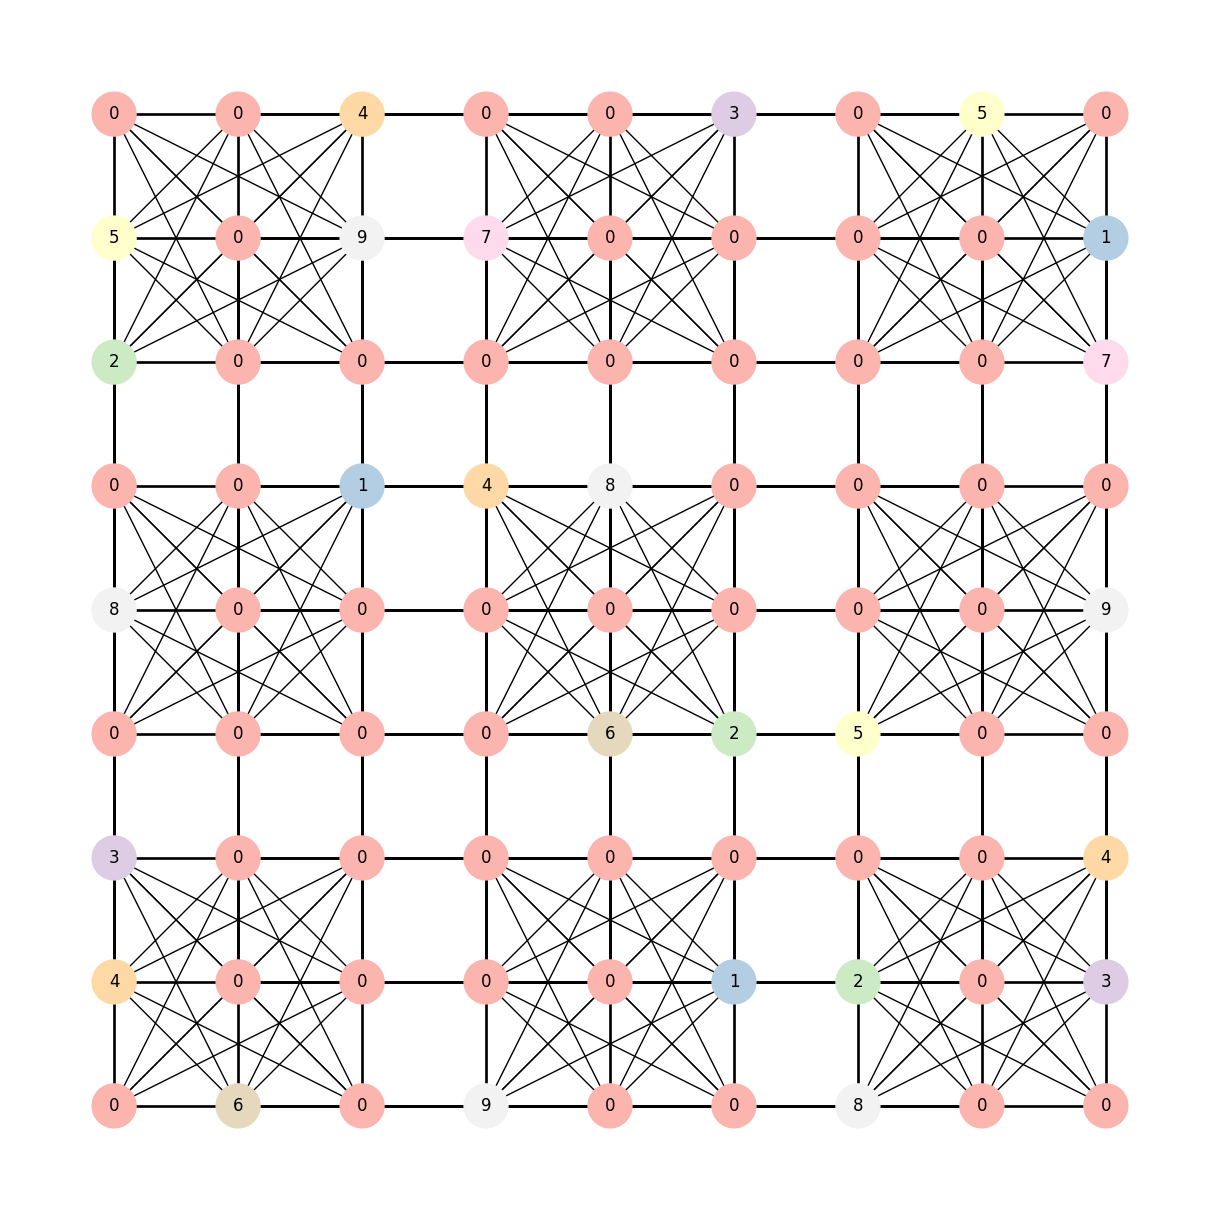

In [3]:
n = 3
G = nx.sudoku_graph(n)
mapping = dict(zip(G.nodes(), puzzle.flatten()))
pos = dict(zip(list(G.nodes()), nx.grid_2d_graph(n * n, n * n)))

# 我们将节点 1-9 映射到一个颜色图
low, *_, high = sorted(mapping.values())
norm = mpl.colors.Normalize(vmin=low, vmax=high, clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Pastel1)

# 绘制图
plt.figure(figsize=(12, 12))
nx.draw(
    G,
    labels=mapping,
    pos=pos,
    with_labels=True,
    node_color=[mapper.to_rgba(i) for i in mapping.values()],
    width=1,
    node_size=1000,
)
plt.show()

现在，我们可以使用贪心图着色算法来解决这个问题，它是一个NP难问题，因此某种程度的暴力破解是过程的一部分。

> 图 G 的 k-着色是一种顶点着色，它将 G 的每个顶点分配给 k 种可能颜色中的一种（即顶点着色），使得没有两个相邻顶点接收相同的颜色。

在这种情况下我们需要多少种颜色？9种。

注意：这不仅仅是直觉，正式地说，9是数独图 $n^2 * n^2$ 的2-距离着色问题的色数，你可以在[这里](https://mast.queensu.ca/~murty/sudoku-ams.pdf)了解更多！

让我们生成一个已解决的网格，我们将尝试可视化它。

In [4]:
from random import sample


# 生成随机数独
def generate_random_sudoku(n):
    side = n * n

    def _pattern(r, c):
        return (n * (r % n) + r // n + c) % side

    rBase = range(n)
    rows = [g * n + r for g in sample(rBase, n) for r in sample(rBase, n)]
    cols = [g * n + c for g in sample(rBase, n) for c in sample(rBase, n)]
    nums = sample(range(1, n * n + 1), n * n)
    board = [nums[_pattern(r, c)] for r in rows for c in cols]
    return board

现在我们修改节点到这个已解决数独的映射。

In [5]:
board = generate_random_sudoku(n)
mapping = dict(zip(G.nodes(), board))

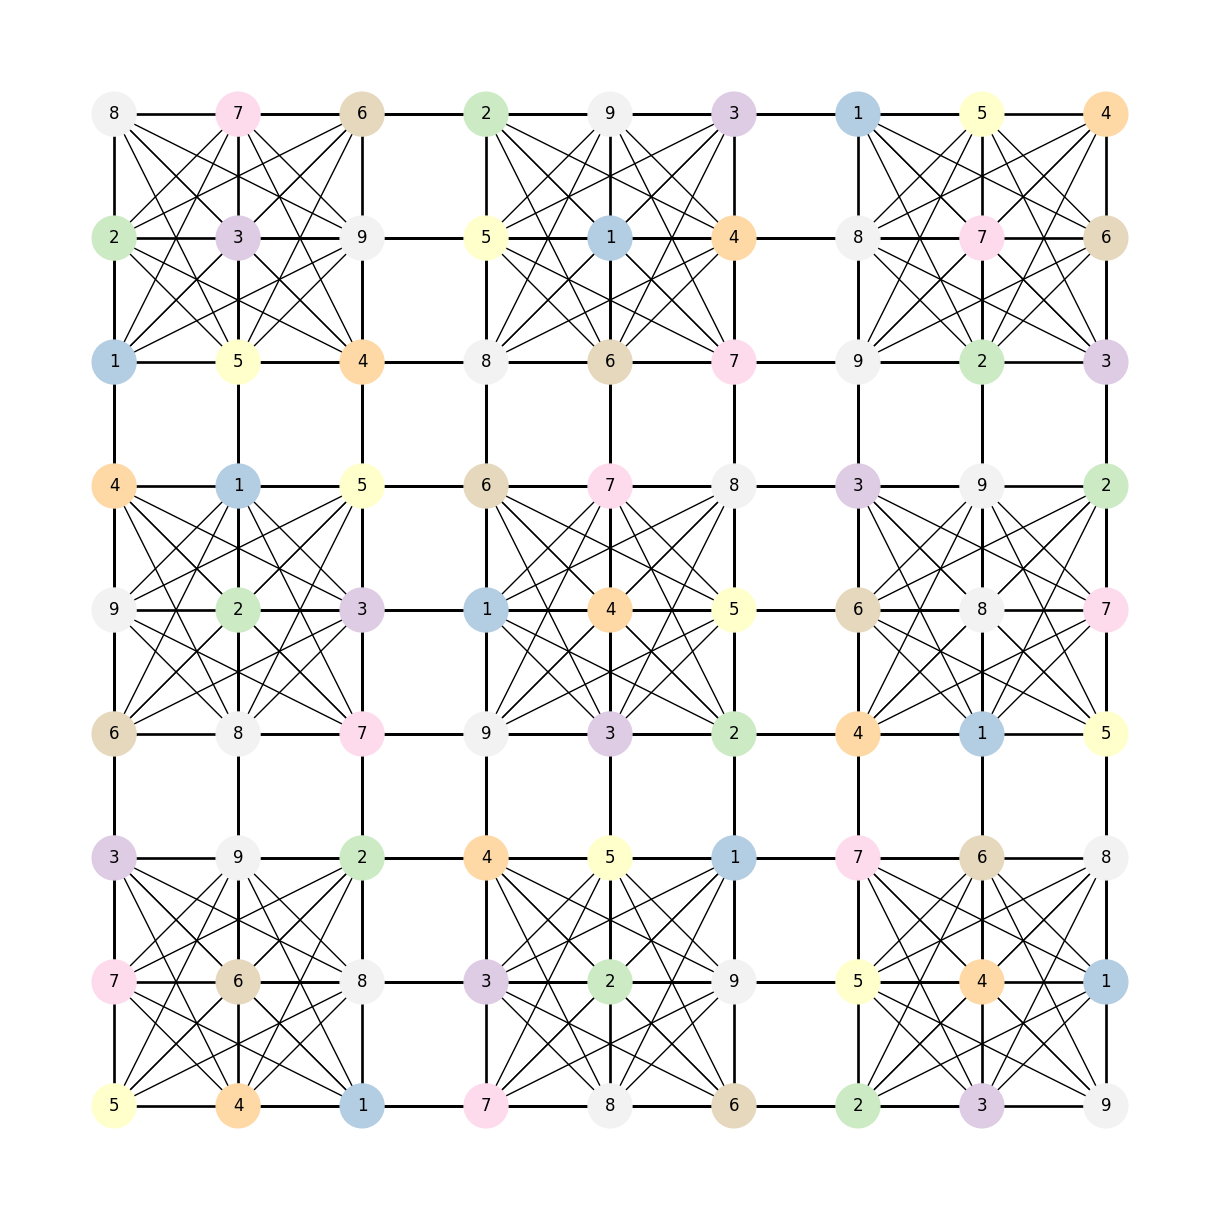

In [6]:
plt.figure(1, figsize=(12, 12))
nx.draw(
    G,
    pos=pos,
    labels=mapping,
    node_size=1000,
    node_color=[mapper.to_rgba(i) for i in mapping.values()],
    with_labels=True,
)

plt.show()

In [7]:
G = nx.sudoku_graph(n=3)

In [8]:
len(G.edges())

810

为了理解和可视化同行、同宫或同列的约束，更仔细地观察边可能会有所帮助。

首先，假设我们有这个图 `G`，现在假设我们想要分别检查所有三种不同类型的约束，我们需要区分三种不同类型的边（有810条！），让我们来做这个！

让我们快速看一下 networkx 在一个空的（未着色或未标记的）数独图上绘制的内容。

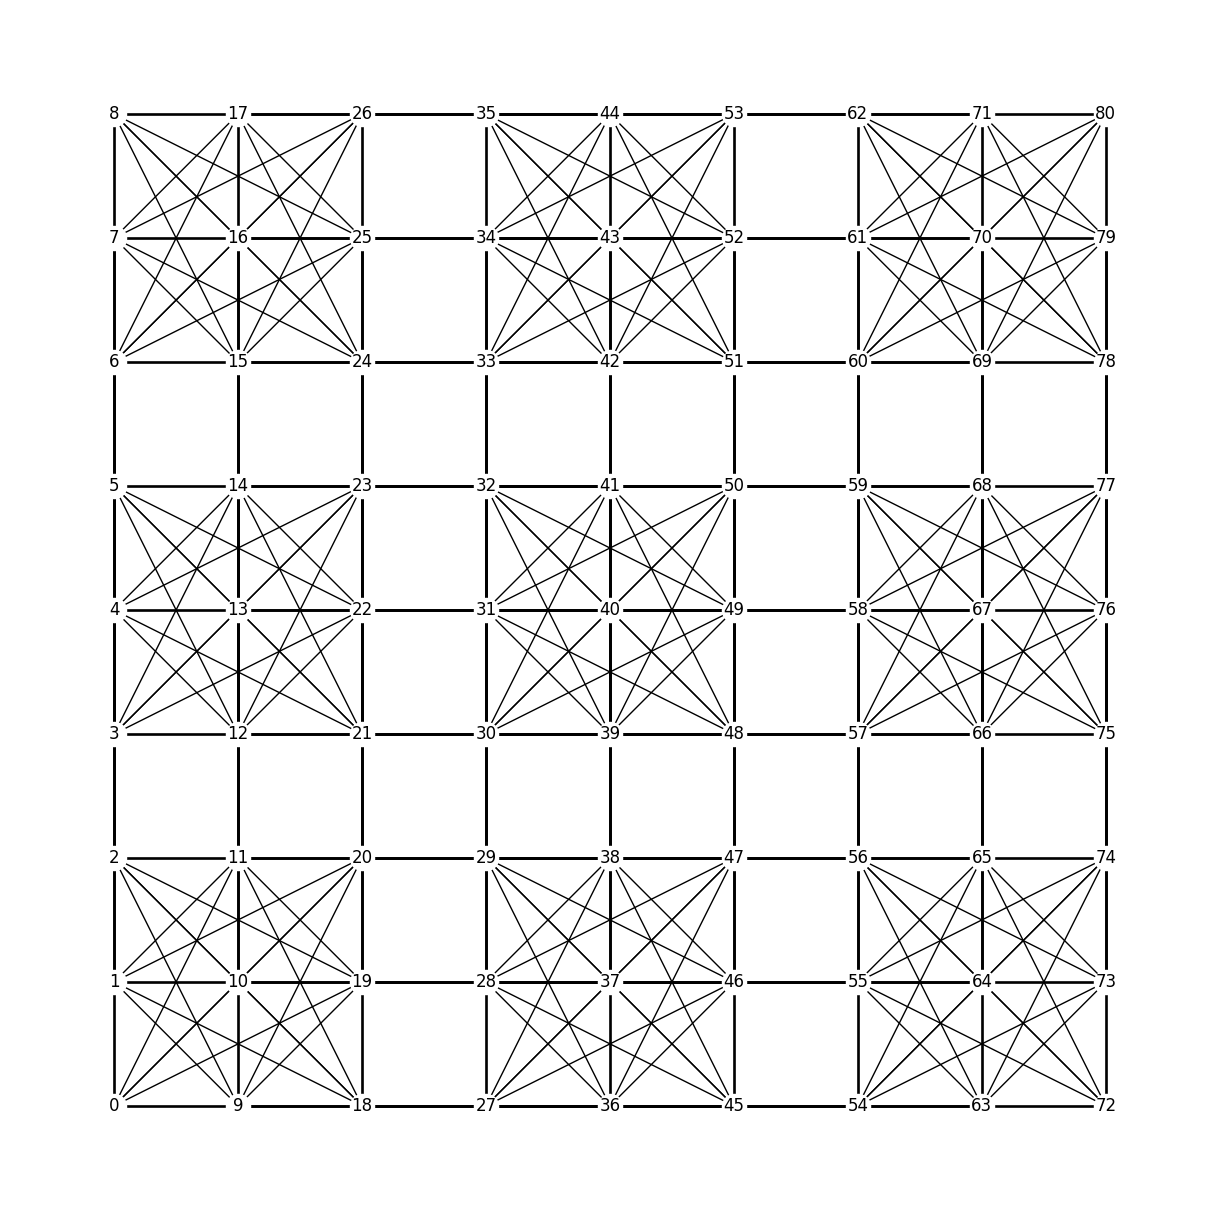

In [9]:
plt.figure(figsize=(12, 12))
pos = dict(zip(list(G.nodes()), nx.grid_2d_graph(n * n, n * n)))
nx.draw(G, pos=pos, node_color="white", with_labels=True)
plt.show()

好了，所有的节点都按列堆叠从0到80索引，现在我们将这里的三种不同类型的边分开。

In [10]:
import itertools


def separate_edges(n):
    G = nx.sudoku_graph(n)
    box_edges = []
    row_edges = []
    column_edges = []
    boxes = []
    for i in range(n):
        for j in range(n):
            box = [
                (n) * i + j * (n * n * n) + (n * n) * k + l
                for k in range(n)
                for l in range(n)
            ]
            boxes.append(box)

    for i in range(n * n):
        row_edges += list(
            itertools.combinations([i + (n * n) * j for j in range(n * n)], 2)
        )
        box_edges += list(itertools.combinations(boxes[i], 2))
        column_edges += list(
            itertools.combinations(list(G.nodes())[i * (n * n) : (i + 1) * (n * n)], 2)
        )
    return row_edges, box_edges, column_edges


def plot_edge_colored_sudoku(n=3, layout="grid"):
    row_edges, box_edges, column_edges = separate_edges(n)
    G = nx.sudoku_graph(n)
    board = generate_random_sudoku(n)
    mapping = dict(zip(G.nodes(), board))

    plt.figure(figsize=(12, 12))
    if layout == "circular":
        pos = nx.circular_layout(G)
    if layout == "grid":
        pos = dict(zip(list(G.nodes()), nx.grid_2d_graph(n * n, n * n)))

    nx.draw(G, pos=pos, labels=mapping, with_labels=True, node_color="orange")
    nx.draw_networkx_edges(G, pos=pos, edgelist=box_edges, edge_color="tab:gray")
    nx.draw_networkx_edges(
        G, pos=pos, edgelist=row_edges, width=2, edge_color="tab:blue"
    )
    nx.draw_networkx_edges(
        G, pos=pos, edgelist=column_edges, width=2, edge_color="tab:green"
    )
    plt.show()

好了，是时候绘制了！

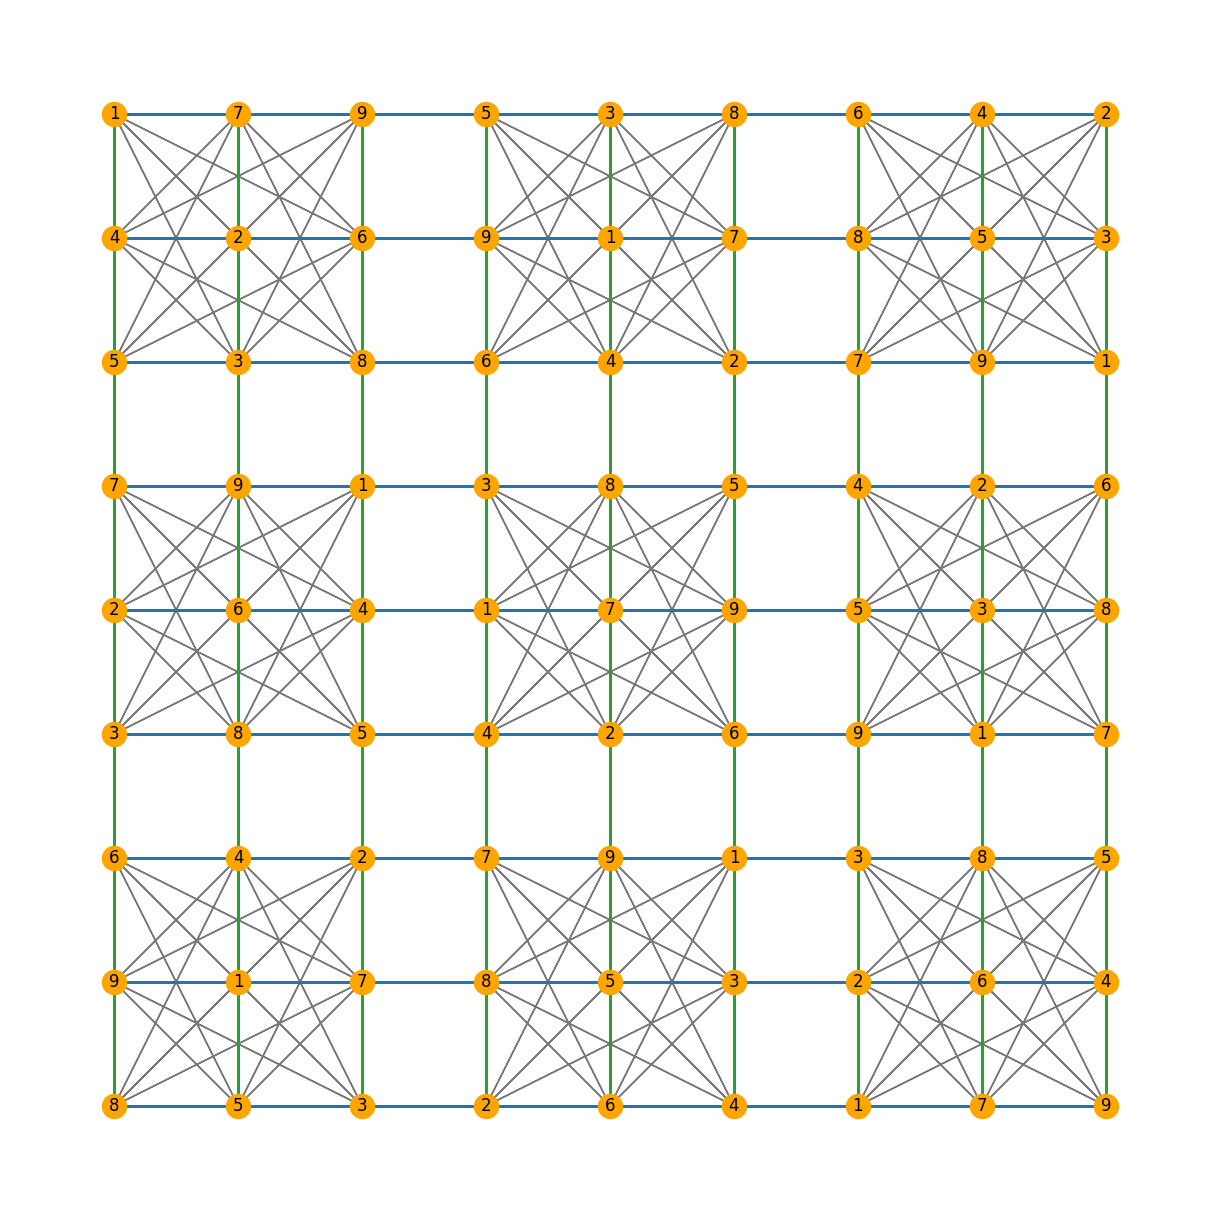

In [11]:
plot_edge_colored_sudoku()

让我们稍微改变一下布局，看看所有因为重叠而看不见的边。

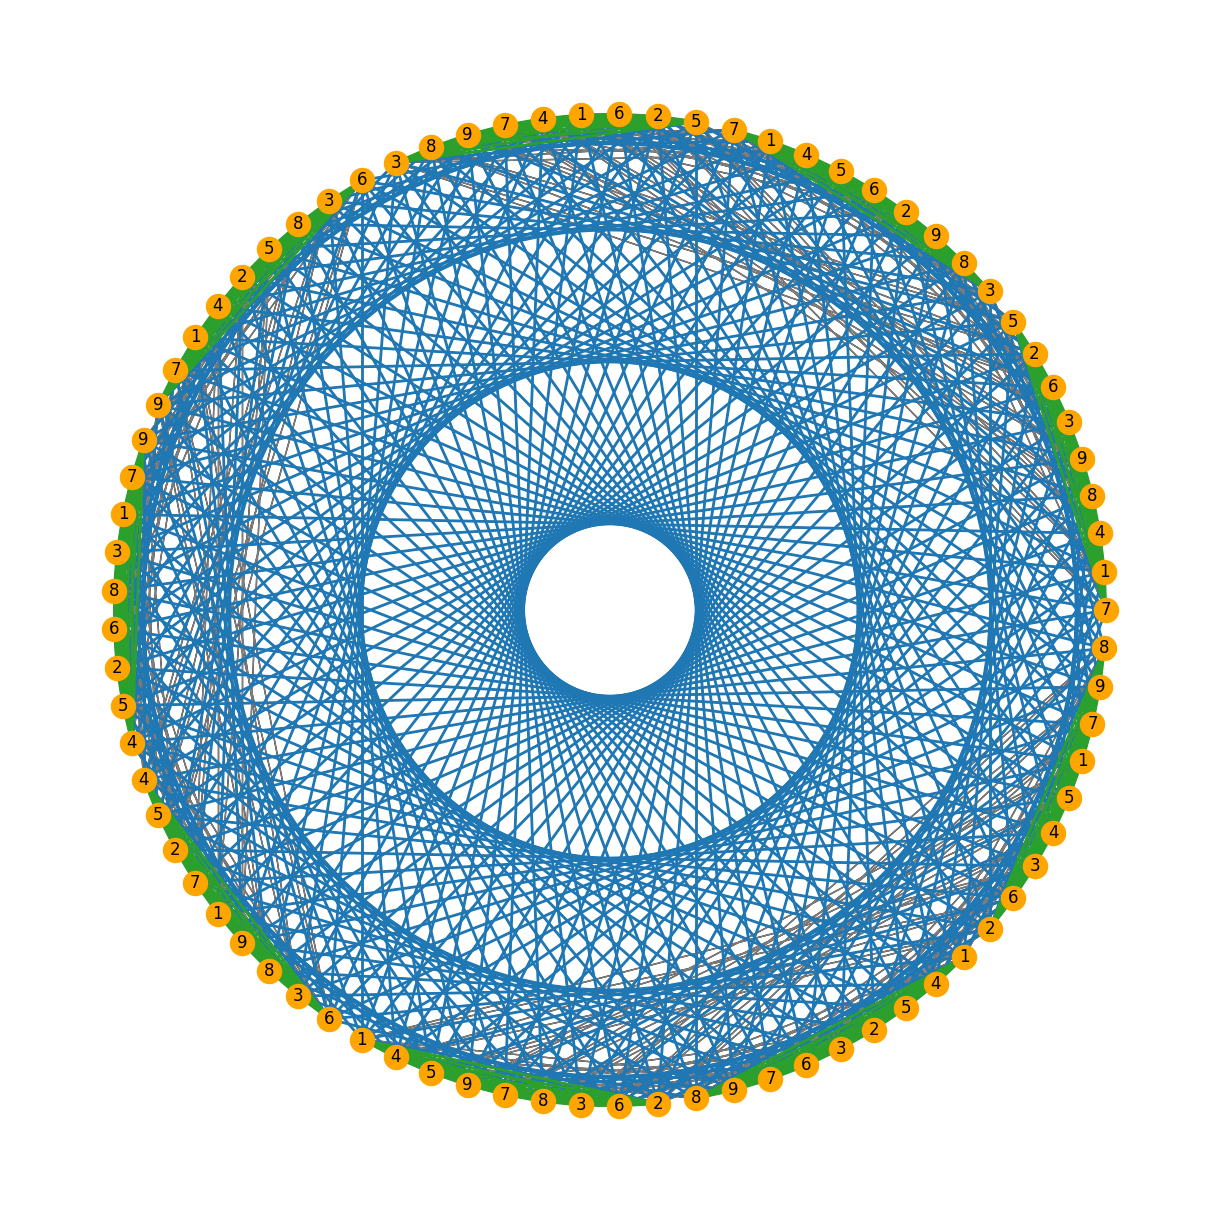

In [12]:
plot_edge_colored_sudoku(layout="circular")

很漂亮！现在，让我们看看如果数独是16 x 16的网格而不是9 x 9的网格，数独图会是什么样子。

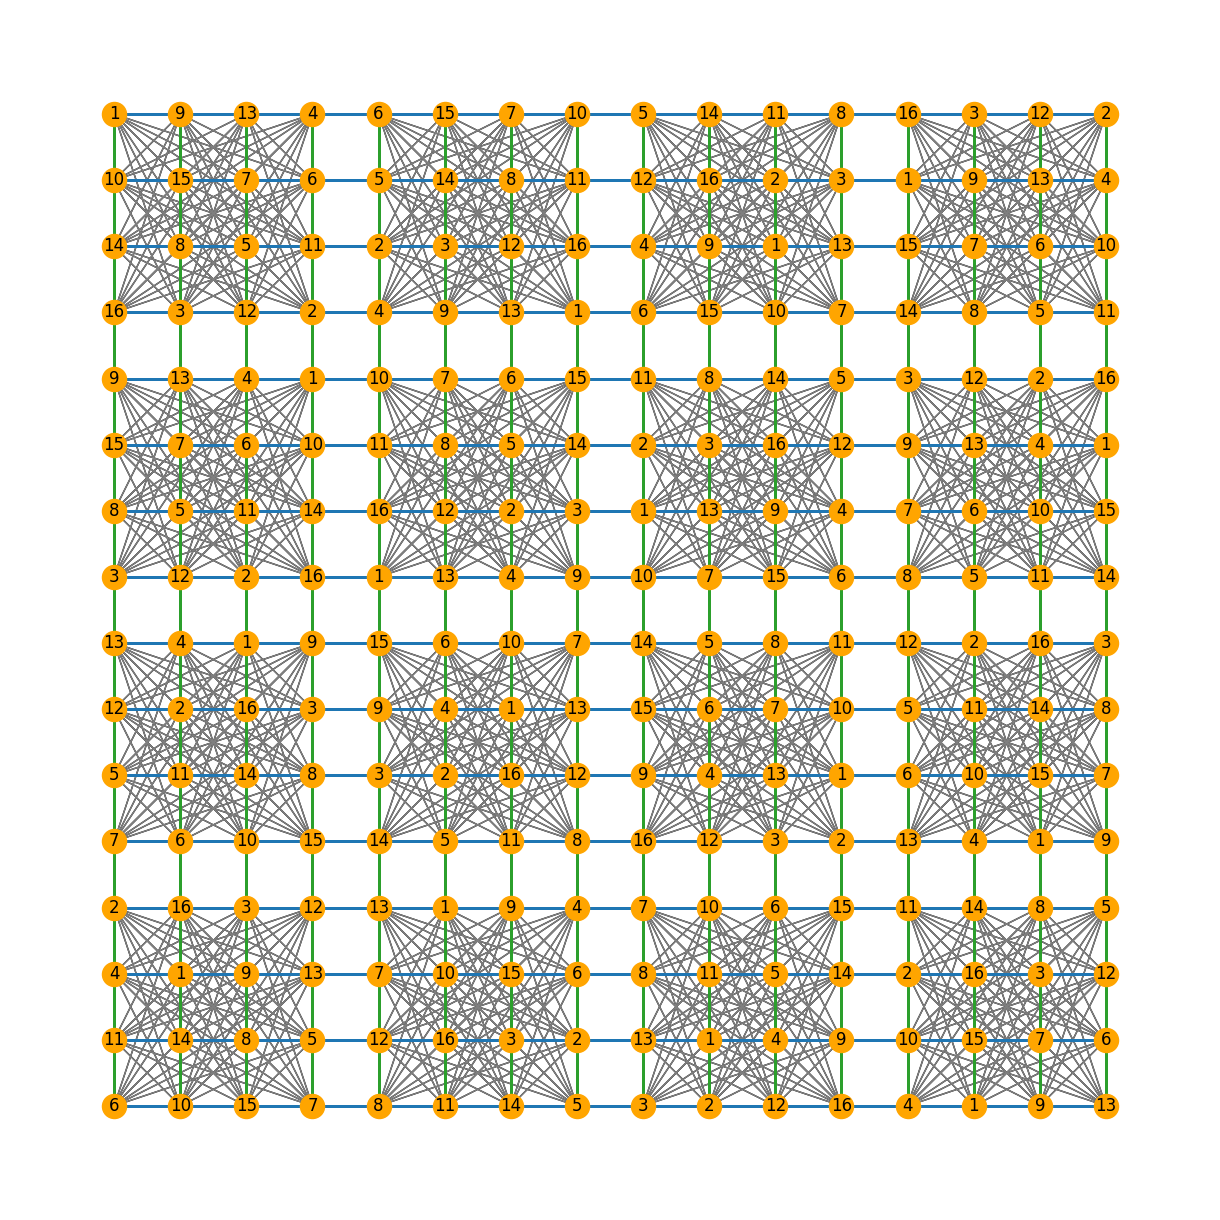

In [13]:
plot_edge_colored_sudoku(n=4)

## 参考文献

[Wikipedia - 数独图](https://en.wikipedia.org/wiki/Sudoku_graph)